# Introduction to networks, part I

In the first part of this introductory tutorial we focus on basics of working with graphs using [`igraph` package for Python](https://python.igraph.org/en/stable/),
which provides efficient tools for analyzing network/graph data. Unlike another popular package `networkx`, `igraph` core is implemented in C (i.e. compiled code),
so the computations are much faster and scale very well also to large graphs.

Another good and efficient network package for Python, which may be of interest, is [`graph_tool`](https://graph-tool.skewed.de/).
It is specialized in statistical inference for networks and in particular in statistically optimal community detection. However,
we will not discuss it here and instead just focus on `igraph`.

In this part of the tutorial we will focus on basics of working with graphs, including instantiation of graph objects, manipulation of vertices and edges,
calculating basic numerical descriptors as well as graph plotting.

**NOTE.**

Check [`igraph` documentation](https://python.igraph.org/en/stable/) for details not covered in this tutorial.

In [1]:
# Load libraries
# !pip install numpy matplotlib python-igraph>=0.10.4
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt

# IGraph configuration
# Set configuration variables
ig.config["plotting.backend"] = "matplotlib"  # use Matplotlib as plotting backend
ig.config["plotting.vertex_color"] = "white"
ig.config["plotting.vertex_size"] = "0.5"

## Instatiation of graph objects

### Creating graphs by hand and basics of the data model

We first create a simple graph by hand. Even though typically this is not how we load graph objects to a current sesssion, it gives us a good opportunity for understanding the basic data model of `igraph`.

Below we create an empty undirected graph (all links are bidirectional). We remember that the basic definition of a graph is in terms of a simple 2-tuple $G = (V, E)$ consisting
of a set $V$ of vertices and a set $E$ of edges (links between the vertices). It captures the essense, but in practice a richer definition is used:

$$
G = (V, E, \mathcal{M}_G, \mathcal{M}_V, \mathcal{M}_E)
$$
where $\mathcal{M}_G, \mathcal{M}_V, \mathcal{M}_E$ are graph, vertex and edge metadata respectively. We will talk about vertex and edge metadata later.
Graph metadata is just a set of arbitrary information associated with the graph $G$.

In [2]:
# Create an empty undirected graph
G = ig.Graph(directed=False)

G.summary()
# The summary method tells us that the graph is undirected (U) and has 0 nodes and 0 links

'IGRAPH U--- 0 0 -- '

In [3]:
# We can attach arbitrary graph-level metadata
G["name"] = "Sample graph"
G["name"]

'Sample graph'

In [4]:
# List defined graph-level attributes
G.attributes()

['name']

### Nodes and edges

Let us now add two nodes to the graph and connect them

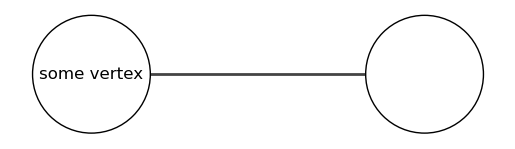

In [5]:
# Create an empty undirected graph
# We create it again, to allow running this code cell
# multiple times with the same results
G = ig.Graph(directed=False)

## Add a single vertex
G.add_vertex()
## Add a single vertex with metadata
G.add_vertex(label="some vertex")

# Vertices are added with incremental integer indices
# So to add edge we refer to them using these numeric values
G.add_edge(0, 1)

# Plot the graph
# We will talk about plotting later
_ = ig.plot(G)

However, very often nodes in our graphs correspond to some meaningful named entities (e.g. persons),
so it would be nice to have some means for refering to graph vertices by name.

And luckily this is possible in `igraph`.

There is vertex attribute `name` which has special semantics. If it is defined, it allows referring to nodes by their names.
To see this we define a new graph, this time directed, in which arrows denote who likes whom in some group, e.g. a class in a school.
For simplicity it will consist of just a few students. We will add all nodes in one go (which is much more efficient than adding them one by one; do you know why?)

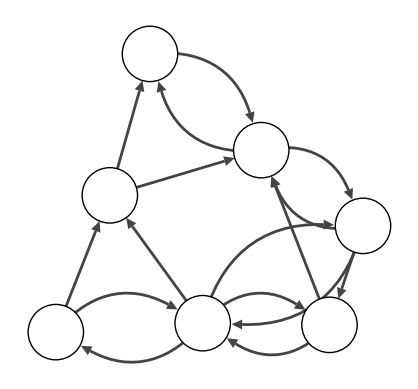

In [6]:
G = ig.Graph(directed=True)

# Define students
G.add_vertices(7, attributes={
    "name": ["Alice", "Bob", "Cedric", "Dora", "Ellie", "Fred", "Gina"]
})

G.add_edges([
    ("Alice", "Bob"),        # Alice likes Bob
    ("Alice", "Dora"),       # Alice likes Dora
    ("Alice", "Ellie"),      # Alice likes Ellie
    ("Alice", "Fred"),       # Alice likes Fred
    ("Bob", "Alice"),        # Bob likes Alice
    ("Bob", "Cedric"),       # Bob likes Cedric
    ("Bob", "Fred"),         # Bob likes Fred
    ("Cedric", "Bob"),       # Cedric likes Bob
    ("Cedric", "Gina"),      # Cedric likes Gina
    ("Dora", "Cedric"),      # Dora likes Cedric
    ("Dora", "Gina"),        # Dora likes Alice
    ("Ellie", "Alice"),      # Ellie likes Alice
    ("Ellie", "Dora"),       # Ellie likes Dora
    ("Fred", "Alice"),       # Fred likes Alice
    ("Fred", "Cedric"),      # Fred likes Cedric
    ("Gina", "Cedric")       # Gina likes Cedric
])

_ = ig.plot(G)

That is a nice graph, but it would be better if we could see the names of the people. Without going into the details of plotting methods, a simple thing
to do to solve this problem is just to define a new vertex attribute called `label`. It is used by default for plotting vertex names.

We can define a new vertex attribute on an existing graph by assigning an item within the vertex sequence (`VertexSeq`) object of a graph (`.vs` attribute).

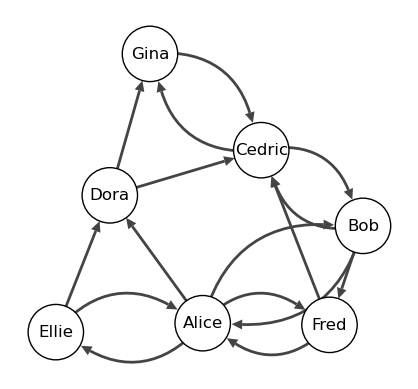

In [7]:
## Define labels (equal to names)
G.vs["label"] = G.vs["name"]

_ = ig.plot(G)

Similarily, edge data (including edge metadata) is stored in `EdgeSeq` object that can be accessed through `.es` attribute.
It can be used in the same way to define edge attrbitues, but we will ignore it for now. Instead, let us just print the edge sequence
to see all the edges defined in `G`.

In [8]:
G.es

Well, this is not very informative, so instead let us iterate over all edges in `G` to see that each of them has its unique integer identifies. Moreover, all edges
know their sources (entitity sending a link) and targets (entity taking the link).

In [9]:
for edge in G.es:
    print(f"id: {edge.index}, source: {edge.source}, target: {edge.index}")

id: 0, source: 0, target: 0
id: 1, source: 0, target: 1
id: 2, source: 0, target: 2
id: 3, source: 0, target: 3
id: 4, source: 1, target: 4
id: 5, source: 1, target: 5
id: 6, source: 1, target: 6
id: 7, source: 2, target: 7
id: 8, source: 2, target: 8
id: 9, source: 3, target: 9
id: 10, source: 3, target: 10
id: 11, source: 4, target: 11
id: 12, source: 4, target: 12
id: 13, source: 5, target: 13
id: 14, source: 5, target: 14
id: 15, source: 6, target: 15


Again, this is not super informative as we still do not see any names. Edge objects store source/target information as integers corresponding to numeric vertex index values. However, we can easily use these integers to resolve names. This is possible, because we can use them to index `VertexSeq` to access the vertex objects storing all the vertex metadata and retrieve the names from there. There is also a shortcut for doing exactly that. We can use `.[target|source]_vertex` attributes to access the vertex object directly.

Moreover, just for the sake of example, here we will use only edges which are mutual (i.e. two persons like each other).

In [10]:
for edge in G.es:
    if edge.is_mutual(): # check if an edge is reciprocated
        index = edge.index
        source = edge.source_vertex["name"]    # equivalent to G.vs[edge.source]["name"]
        target = edge.target_vertex["name"]    # equivalent to G.vs[edge.target]["name"]
        print(f"edge id: {index} | {source}->{target}")

edge id: 0 | Alice->Bob
edge id: 2 | Alice->Ellie
edge id: 3 | Alice->Fred
edge id: 4 | Bob->Alice
edge id: 5 | Bob->Cedric
edge id: 7 | Cedric->Bob
edge id: 8 | Cedric->Gina
edge id: 11 | Ellie->Alice
edge id: 13 | Fred->Alice
edge id: 15 | Gina->Cedric


#### Edges in undirected graphs

Now an important question is how edges work in undirected graphs. Are there two edges for each pair of connected nodes (one edge in each direction)? Or maybe just one edge per pair, but then who is the source and who is the target?

To answer this question we will consider an undirected version of our class graph. We can use `.as_undirected` method to make an undirected copy of a graph.

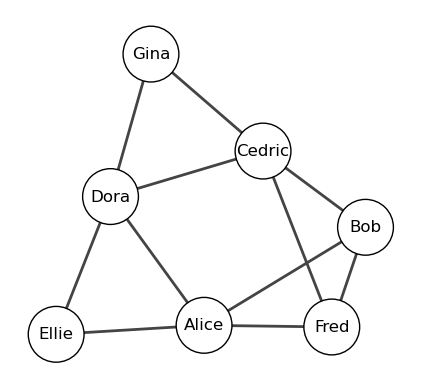

In [11]:
U = G.as_undirected()

_ = ig.plot(U)  # Now it is much simpler!!

Let us now iterate over edges and see their sources and targets.

In [12]:
for edge in U.es:
    print(edge.tuple)   # edge.tuple == (edge.source, edge.target)

(0, 1)
(1, 2)
(0, 3)
(2, 3)
(0, 4)
(3, 4)
(0, 5)
(1, 5)
(2, 5)
(2, 6)
(3, 6)


Note that in all case the first id (source id) is lower than the second id (target id). This is by design, that is, this is how graph libraries like `igraph` typically
define edges in undirected graph. Hence, for undirected graphs the notions of source and target are not well-defined. To access objects corresponding to vertices linked
by an edge it is better to use `.vertex_tuple` attribute. The `.source` and `.target` attributes are still defined for undirected edges and correspond to node with lower
and higher integer id, respectively.

In [13]:
for edge in U.es:
    print(edge.vertex_tuple)

(igraph.Vertex(<igraph.Graph object at 0x7fa32dc0b040>, 0, {'name': 'Alice', 'label': 'Alice'}), igraph.Vertex(<igraph.Graph object at 0x7fa32dc0b040>, 1, {'name': 'Bob', 'label': 'Bob'}))
(igraph.Vertex(<igraph.Graph object at 0x7fa32dc0b040>, 1, {'name': 'Bob', 'label': 'Bob'}), igraph.Vertex(<igraph.Graph object at 0x7fa32dc0b040>, 2, {'name': 'Cedric', 'label': 'Cedric'}))
(igraph.Vertex(<igraph.Graph object at 0x7fa32dc0b040>, 0, {'name': 'Alice', 'label': 'Alice'}), igraph.Vertex(<igraph.Graph object at 0x7fa32dc0b040>, 3, {'name': 'Dora', 'label': 'Dora'}))
(igraph.Vertex(<igraph.Graph object at 0x7fa32dc0b040>, 2, {'name': 'Cedric', 'label': 'Cedric'}), igraph.Vertex(<igraph.Graph object at 0x7fa32dc0b040>, 3, {'name': 'Dora', 'label': 'Dora'}))
(igraph.Vertex(<igraph.Graph object at 0x7fa32dc0b040>, 0, {'name': 'Alice', 'label': 'Alice'}), igraph.Vertex(<igraph.Graph object at 0x7fa32dc0b040>, 4, {'name': 'Ellie', 'label': 'Ellie'}))
(igraph.Vertex(<igraph.Graph object at 0x7f

## Serializing graph objects

We already spent some time defining our simple graph of students, so it would be nice if we did not have to execute all the code everytime we want to use it again.
In other words, how to save a graph object existing in the memory of our current Python process to disk for later use? This process is known as **serialization**
(and it applies not only to graphs but virtually any kind of data).

There are multiple ways in which graphs can be stored on disk. One may use the standard Python `pickle` protocol
but this solution is specific for Python (and also trivial to implement; see [the docs](https://docs.python.org/3/library/pickle.html)),
so we will not discuss it.

### Tabular serialization with `pandas`

A very generic solution is serialization based on simple tabular data. This can be handled in Python quite easily using the `pandas` package.
The process is very simple:

1. Dump a graph to a list of nodes and a list of links. Each list consist of `dict` objects storing vertex/edge metadata.
2. Convert lists to `pandas.DataFrame` instances.
3. Save the dataframes to disk, e.g. as CSV files.

In [14]:
nodes, edges = G.to_dict_list()

In [15]:
nodes

[{'name': 'Alice', 'label': 'Alice'},
 {'name': 'Bob', 'label': 'Bob'},
 {'name': 'Cedric', 'label': 'Cedric'},
 {'name': 'Dora', 'label': 'Dora'},
 {'name': 'Ellie', 'label': 'Ellie'},
 {'name': 'Fred', 'label': 'Fred'},
 {'name': 'Gina', 'label': 'Gina'}]

In [16]:
edges

[{'source': 0, 'target': 1},
 {'source': 0, 'target': 3},
 {'source': 0, 'target': 4},
 {'source': 0, 'target': 5},
 {'source': 1, 'target': 0},
 {'source': 1, 'target': 2},
 {'source': 1, 'target': 5},
 {'source': 2, 'target': 1},
 {'source': 2, 'target': 6},
 {'source': 3, 'target': 2},
 {'source': 3, 'target': 6},
 {'source': 4, 'target': 0},
 {'source': 4, 'target': 3},
 {'source': 5, 'target': 0},
 {'source': 5, 'target': 2},
 {'source': 6, 'target': 2}]

We see that metadata is retained and edges are specified based on vertex ids (so-called `vids` in `igraph` lingo).
Sometimes we may want to refer to nodes using names, so in this case we can use.

Note that below edges are defined in terms of actual vertex names.

In [17]:
nodes, edges = G.to_dict_list(use_vids=False)
edges

[{'source': 'Alice', 'target': 'Bob'},
 {'source': 'Alice', 'target': 'Dora'},
 {'source': 'Alice', 'target': 'Ellie'},
 {'source': 'Alice', 'target': 'Fred'},
 {'source': 'Bob', 'target': 'Alice'},
 {'source': 'Bob', 'target': 'Cedric'},
 {'source': 'Bob', 'target': 'Fred'},
 {'source': 'Cedric', 'target': 'Bob'},
 {'source': 'Cedric', 'target': 'Gina'},
 {'source': 'Dora', 'target': 'Cedric'},
 {'source': 'Dora', 'target': 'Gina'},
 {'source': 'Ellie', 'target': 'Alice'},
 {'source': 'Ellie', 'target': 'Dora'},
 {'source': 'Fred', 'target': 'Alice'},
 {'source': 'Fred', 'target': 'Cedric'},
 {'source': 'Gina', 'target': 'Cedric'}]

Now, converting a list of dictionaries with a common structure to a `pandas` data frame is super easy.

In [18]:
# Nodes data frame
ndf = pd.DataFrame(nodes)

# Save as a CSV
ndf.to_csv("test-nodes.csv", index=False)

ndf

,name,label
0,Alice,Alice
1,Bob,Bob
2,Cedric,Cedric
3,Dora,Dora
4,Ellie,Ellie
5,Fred,Fred
6,Gina,Gina


In [19]:
# Edges data frame
edf = pd.DataFrame(edges)
edf

# Save as a CSV
edf.to_csv("test-edges.csv", index=False)

edf

,source,target
0,Alice,Bob
1,Alice,Dora
2,Alice,Ellie
3,Alice,Fred
4,Bob,Alice
5,Bob,Cedric
6,Bob,Fred
7,Cedric,Bob
8,Cedric,Gina
9,Dora,Cedric


Now we can recreate our original graph from the data saved on disk.
To this purpose we use `igraph.Graph.DataFrame` constructor (as most non-standard constructor methods in Python it is defined as a class method of the type object).

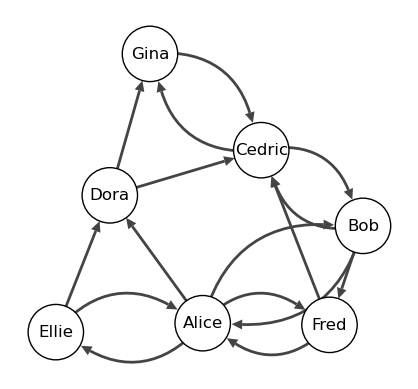

In [20]:
ndf = pd.read_csv("test-nodes.csv")
edf = pd.read_csv("test-edges.csv")

G2 = ig.Graph.DataFrame(
    edges=edf,
    vertices=ndf,
    directed=True,  
    use_vids=False  # since we want to use name-based references
)
_ = ig.plot(G2)

In [21]:
## NOTE.
# Data frames can be produced in an even simpler way
# but this does not retain metadata nor use names
# for defining edges
ndf = G.get_vertex_dataframe()
edf = G.get_edge_dataframe()
ndf, edf

(             name   label
 vertex ID                
 0           Alice   Alice
 1             Bob     Bob
 2          Cedric  Cedric
 3            Dora    Dora
 4           Ellie   Ellie
 5            Fred    Fred
 6            Gina    Gina,
          source  target
 edge ID                
 0             0       1
 1             0       3
 2             0       4
 3             0       5
 4             1       0
 5             1       2
 6             1       5
 7             2       1
 8             2       6
 9             3       2
 10            3       6
 11            4       0
 12            4       3
 13            5       0
 14            5       2
 15            6       2)

Last but not least, often all the important information we care about is the graph adjacency structure (i.e. who connects to whom)
and maybe names of the nodes. In this case serialization based on the edge data frame is possible. `igraph` can deduce what is the vertex
set from the provided list of edges.

**NOTE.**
This will work fully correctly only for graphs without isolated nodes (i.e. nodes without any connections),
since isolated nodes - by definition - do not occur in edgelist.

**NOTE.**
Edge data frame is more often called **edgelist**.

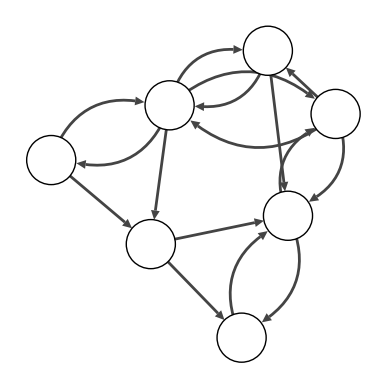

In [22]:
_, edges = G.to_dict_list(use_vids=False)
edf = pd.DataFrame(edges)
G2 = ig.Graph.DataFrame(edf, use_vids=False)
_ = ig.plot(G2)

But note that in the above process we lost the `label` attribute, so we have to recreate it by hand.

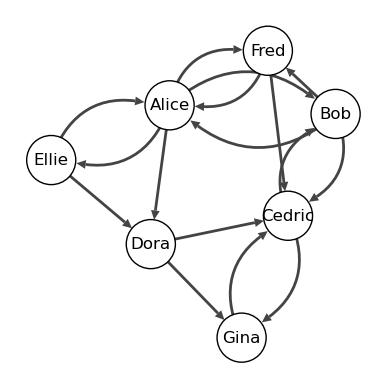

In [23]:
G2.vs["label"] = G2.vs["name"]
_ = ig.plot(G2)

### Serialization using `GraphML` format

`GraphML` is a popular format for graph-data supporting rich metadata annotations (it is based on the standard `XML` data format). 
Thus, it can handle easily most of the practically important cases. Moreover, `igraph` allows for easy reading and writing `gzip` compressed
`.graphml` files, which is particularily convenient when working with large graph objects.

This approach is much more convenient than tabular serialization, since it allows for moving a graph around using only a single file
than can be loaded into memory directly as `igraph.Graph` object using a single method call. Let us now see how it works.

Since it is usually a good practice to compress your data files, we will use the compressed variants of the `GraphML` methods.
They can be recognized by the `z` suffix. Uncompressed methods have the same names, but without the suffix.

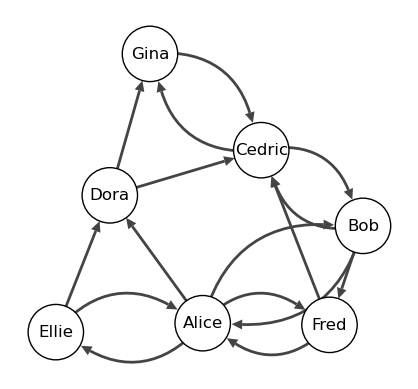

In [24]:
G.write_graphmlz("students.graphml.gz")
G2 = ig.Graph.Read_GraphMLz("students.graphml.gz")

_ = ig.plot(G2)

### Excercise 1.

Here is a simple sociogram (a name often used to visual representations of social networks).
Build an `igraph` object representing this network and save it as a `.graphml` file (compressed or not).
Load the saved file into memory and plot it to see whether it correctly represents the given sociogram.

![simple sociogram](simple-sociogram.png)

Do the above for the two following cases.

1. Create an undirected graph (sociogram has no directed arrows, so it is undirected).
2. Create a directed graph. You are free to choose whatever edge directions you prefer.

## Manipulating graphs

We now know the basics of how networks are represented and stored (in memory and on disk) in `igraph`. Thus, we are ready to learn more about how to manipulate, transform and query networks once we have them loaded in our Python process.

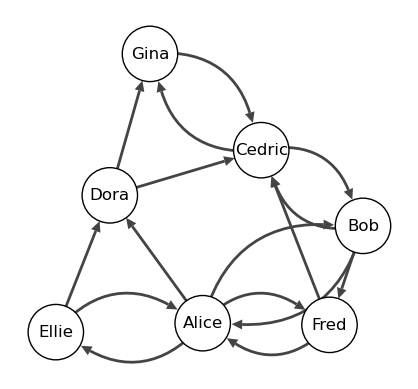

In [25]:
_ = ig.plot(G)

### Selecting vertices and induced subgraphs

Very often we may be interested only in a particular subset of vertices and a **subgraph induced by this selection**.
An induced subgraph is a graph consisting of a subset of $V$ and all links between the selected nodes.

Below we first select only Gina, Dora, Cedric and Bob and then find the corresponding induced subgraph.
Our main trick will be `.select` method of `VertexSeq` class.

We do not have time to study the `.select` method in detail, but it can be very convenient and powerful,
so it is recommended take a look at its documentation: `igraph.VertexSeq.select?`.

In [26]:
names = ["Gina", "Dora", "Cedric", "Bob"]

vertices = G.vs.select(name_in=names)
# Note that '_in' suffix means that we look for
# vertices with 'name' attribute values contained in a given list

# We check that the number of selected persons is correct
len(vertices)

4

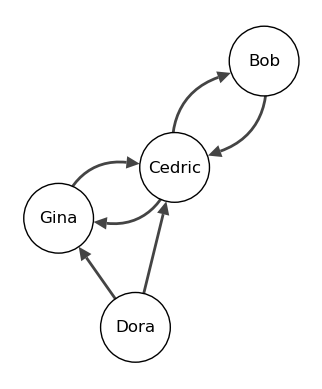

In [27]:
sub = G.subgraph(vertices)
_ = ig.plot(sub)

## Selecting edges

Similarily, we can select edges. After that we can look for an edge subgraph induced by our selection. In this case there are two options.

1. Graph with selected edges and all vertices
2. Graph with selected edges and only vertices connected by them

As previously, we use `.select` method, but this time of course the variant defined on `EdgeSeq` class.
Here we will select only edges pointing to Cedric (so we want to find students who like Cedric).

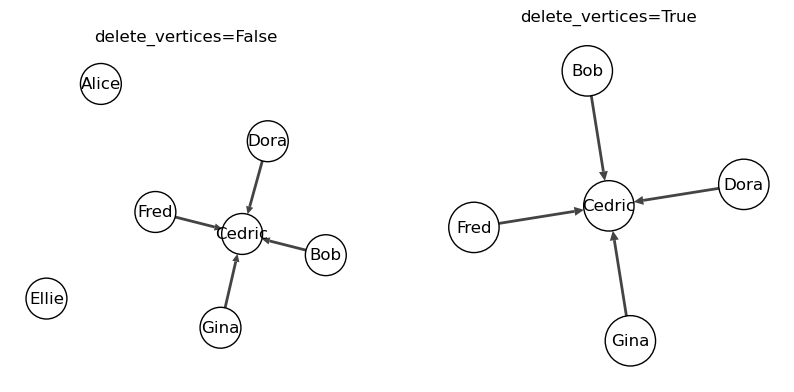

In [28]:
# First we translate names to vertex ids
vids = G.vs.select(name="Cedric").indices
edges = G.es.select(_target_in=vids)

fig, axes = plt.subplots(ncols=2, figsize=(10, 20))

for ax, delete in zip(axes.flat, [False, True]):
    sub = G.subgraph_edges(edges, delete_vertices=delete)
    ig.plot(sub, target=ax)
    ax.set_title(f"delete_vertices={delete}")

### Removing nodes and edges

We already know how to add nodes and edges. But sometimes we also may need to remove them, for instance while modeling an evolution
of a network.

Let us say that something unpleasant happened and Dora does not like Cedric anymore. How can we reflect that?

The most convenient approach is to use `.select` method again followed by `.delete` method.

**NOTE.**

There are `.remove_edges` and `.remove_vertices` methods defined on graph objects, and it is worthwhile to look at them.
However, `.select` approach is typically more convenient, so we focus on it.

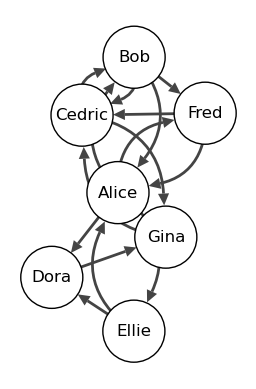

In [29]:
U = G.copy()

source_id = G.vs.select(name="Dora").indices[0]
target_id = G.vs.select(name="Cedric").indices[0]

U.es.select(_source=source_id, _target=target_id).delete()

_ = ig.plot(U)

### Exercise 2.

Use an analogous strategy to define (and plot) the class graph without Cedric and Dora.

## Basic graph descriptors

Here we go through a brief overview of basic graph descriptors.
We focus only on a few most important examples per category
(as there are really dozens of different descriptors for any occasion one can find in the literature).

### Global descriptors

In [30]:
(
    G.vcount(),                   # Number of nodes
    G.ecount(),                   # Number of edges
    G.density(),                  # Edge density
    G.transitivity_undirected()   # clustering/trasitivity coefficient
)

(7, 16, 0.38095238095238093, 0.46153846153846156)

#### Exercise 3.

Calculate edge density of the class graph using only `.vcount()` and `.ecount()` methods.

#### Question

Look at the density and transitivity (undirected) of the graph. What the values seem to suggest?

### Node and edge descriptors

They can be roughly divided into two main families:

1. **Centrality measures.** They are aimed at capturing the importance of a given node/edge for the global structure of the network (in some particular sense).
2. **Local structure measures.** They are aimed at capturing some structural properties of a local subgraph around a given node/edge.

Moreover, all descriptors can be organized in hierarchy based on how much structural information one need to compute them.

* **1st order.** Descriptors of which values depend only on the properties of a given node/edge. No knowledge of properties of neighbors is needed.
* **2nd order.** Descriptors that depends also on properties of neighbors.
* **3rd order.** As above + properties of the neighbors of neighbors (2nd order neighbors).
* And so on.
* **Global.** Descriptors depending on the full knowledge of the entire network.


We will now try to understand the above classification based on three different measures.

#### Node degree

This is the most basic but also most fundamental centrality measure. Node degree is just the number of connections a node has.
In directed networks we distinguish also out-degrees (number outgoing links) and in-degrees (number of incoming links).

In social networks, in-degrees are often interpreted in terms of popularity and out-degrees in terms of sociability.

,name,degree,indegree,outdegree
0,Alice,7,3,4
1,Bob,5,2,3
2,Cedric,6,4,2
3,Dora,4,2,2
4,Ellie,3,1,2
5,Fred,4,2,2
6,Gina,3,2,1


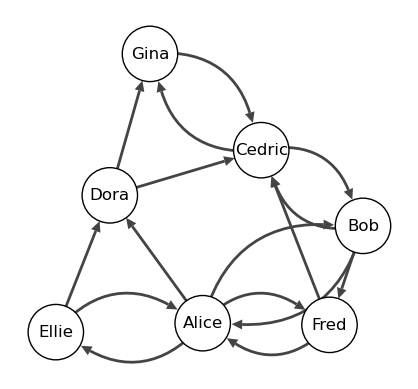

In [31]:
_ = ig.plot(G)

pd.DataFrame({
    "name": G.vs["name"],
    "degree": G.degree(mode="all"),
    "indegree": G.degree(mode="in"),
    "outdegree": G.degree(mode="out")
})


##### Question

Where in the classification does node degree as a descriptor fit in?

####

##### Adjacency matrices, random walks and node degree as a centrality measure 

To better understand why node degree is a centrality measure we first review the notion of **adjacency matrix**.
It is a matrix such that $A_{ij} = 1$ if $i \to j$ or $A_{ij} = 0$ otherwise (some times the oppositve convention $j \to i$ is used, but `igraph` follows the first one).

array([[0, 1, 0, 1, 1, 1, 0],
       [1, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0]])

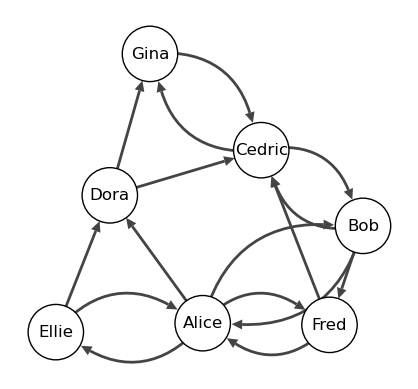

In [32]:
_ = ig.plot(G)

A = np.array(list(G.get_adjacency()))
A

Importantly, here row sums of $A$ give out-degrees and column sums give in-degrees. Let us check this.

In [33]:
A.sum(axis=0) == G.degree(mode="in")

array([ True,  True,  True,  True,  True,  True,  True])

In [34]:
A.sum(axis=1) == G.degree(mode="out")

array([ True,  True,  True,  True,  True,  True,  True])

Note also that the sums of in- and out-degrees are always equal.

**Question.**

Can you explain why?

In [35]:
sum(G.degree(mode="in")) == sum(G.degree(mode="out"))

True

Now let us consider another important notion of a random walk. It is a simple process in which we start from a node and then
travel across a network by jumping to randomly selected adjacent node at each time step.

It is very easy to simulate in `igraph`. Below we visualize the process with a simple simulation, which may be interpreted, for instance,
as a depiction of how a secret note may travel from student to student during a class. We show 5 time steps starting from a randomly
selected node.

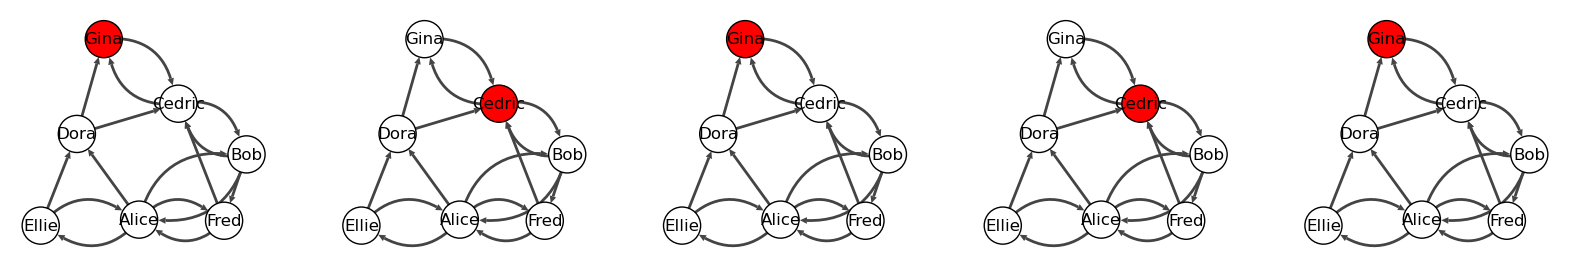

In [36]:
n_steps = 5
start = np.random.randint(0, G.vcount())
fig, axes = plt.subplots(ncols=n_steps, figsize=(20, 20))

for ax, vid in zip(axes.flat, G.random_walk(start=start, steps=5)):
    colors = np.where(np.array(G.vs.indices) == vid, "red", "white")
    ig.plot(G, vertex_color=colors, target=ax)

Now, when we consider random walks of length just $1$ starting from a randomly selected node
(with selection probabilities proportional to nodes' out-degrees), 
then the probability distribution over the terminal nodes will converge to values proportional to node in-degrees.

**Question.** Can you explain why? Try to prove it (it is simple!)

Anyways, let us see this.

Pearson r: 1.000


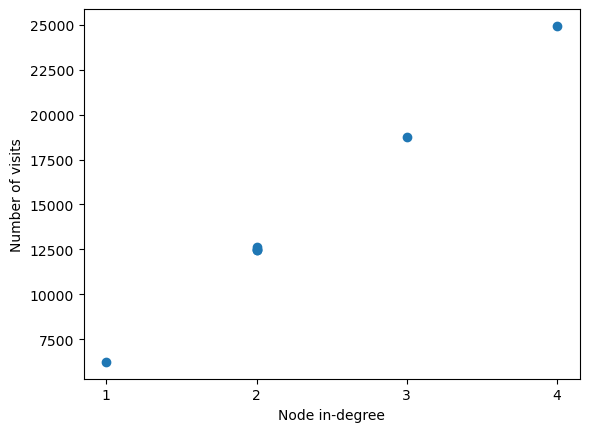

In [37]:
n_rep = 100000

outdegseq = np.array(G.degree(mode="out"))
start = np.random.choice(G.vcount(), size=n_rep, p=outdegseq/outdegseq.sum())
terminal = np.empty(n_rep, dtype=int)

for i, vid in enumerate(start):
    terminal[i] = G.random_walk(vid, steps=1)[-1]

visits = pd.Series(terminal) \
    .value_counts() \
    .reindex(range(G.vcount())) \
    .fillna(0) \
    .astype(int)

data = pd.DataFrame({
    "indegree": G.degree(mode="in"),
    "visits": visits 
})

fig, ax = plt.subplots()

ax.scatter(data["indegree"], data["visits"])
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.set_xlabel("Node in-degree")
ax.set_ylabel("Number of visits")

print(rf"Pearson r: {data.corr().iloc[0, 1]:.3f}")

#### Local clustering

A different sort of measure is local clustering coefficient. It is not a centrality measure but instead a measure of
local structure. It is applicable primarily to undirected graphs (although generalizations exist) and defined
as the ratio of triangles to the maximum possible number of triangles a given node can belong to.

$$
c_i = \frac{T_i}{d_i(d_i-1)}
$$

**Question.** Can you explain why the above formula makes sense?

Below we consider the undirected counterpart of our class graph.

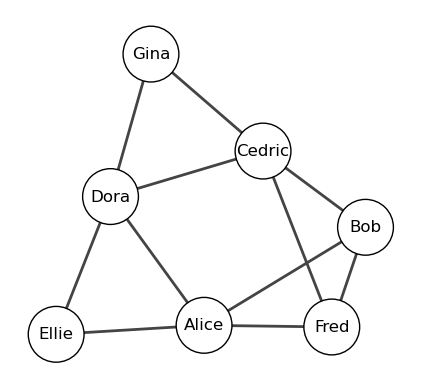

In [38]:
U = G.as_undirected()
_ = ig.plot(U)

We can relate the osberved values of the local clustering coefficient to node degrees and see that local clustering
tend to decrease with node degree.

In [39]:
pd.DataFrame({
    "degree": U.degree(),
    "clutsering": U.transitivity_local_undirected()
}).sort_values("degree")

,degree,clutsering
4,2,1.000000
6,2,1.000000
1,3,0.666667
5,3,0.666667
0,4,0.333333
2,4,0.333333
3,4,0.333333


This is a very general result that applies to a wide range of situations and graph models.

**Question.**

Do you have any intuition for why this is a case? 
Focus on the denominator in the formula and consider what happens when the degree of the focal node $i$ is high relative to the degrees
of its neighbors.

##### Cliques, motifs and ego-graphs

To understand the structural meaning local clustering coefficient let us now consider important notions of cliques and motifs.
A clique is a fully-connected subgraph, i.e. a subgraph in which every node is linked to every other node.
A triangle is the smallest (non-trivial) clique composed of just three nodes.

So one interpretation of the local clustering coefficient is in terms of the _cliqueness_ of the neighbourhood of a given node.

We can gain a fuller understanding of this by considering the notion of ego-graph, which is a subgraph including a focal node $i$
and its neighbors.

Below we plot ego-graphs of all students.

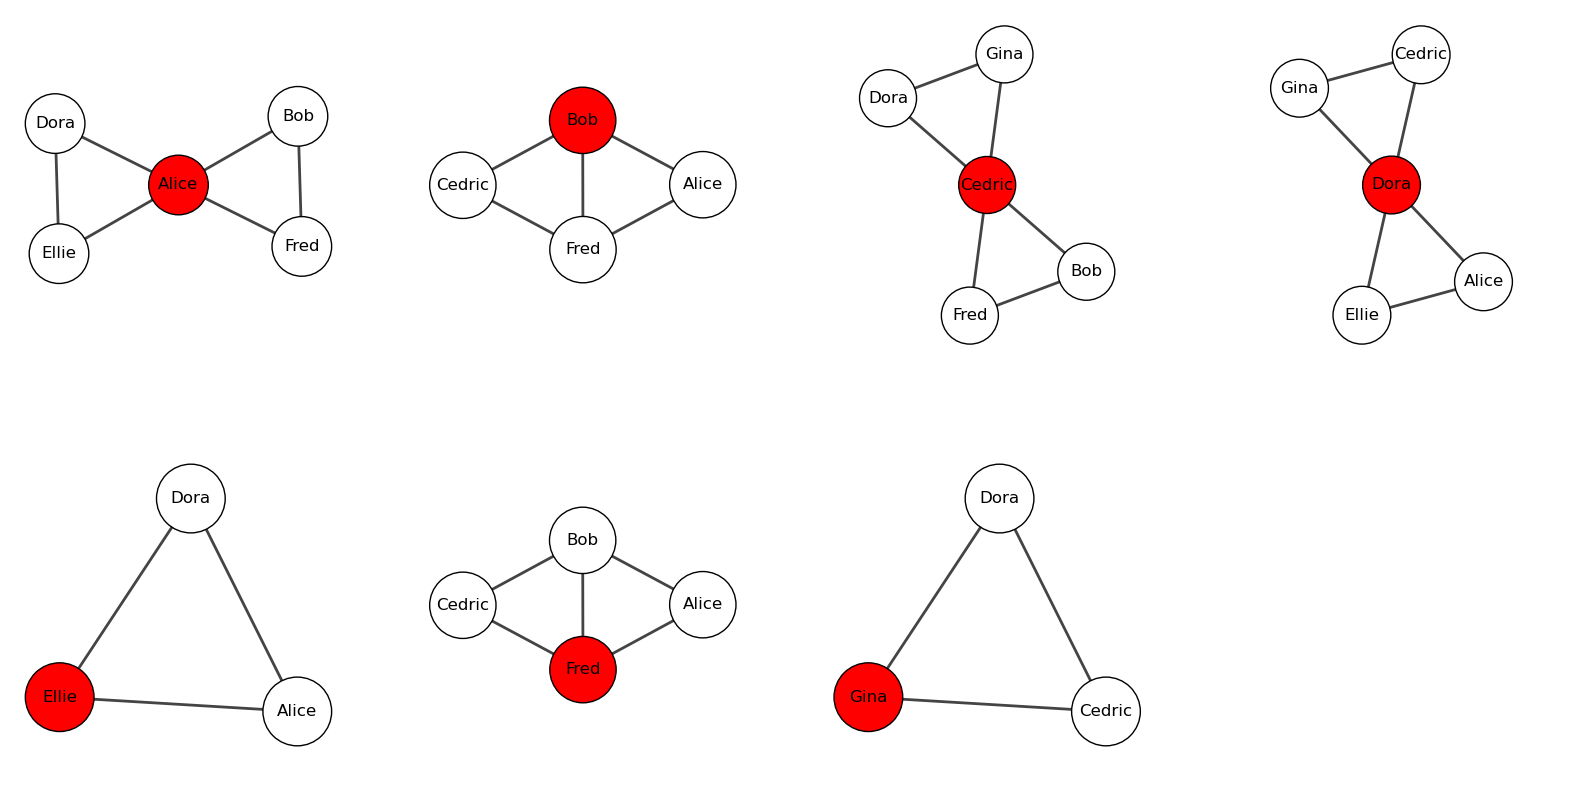

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
# Make last axis object empty
axes.flatten()[-1].axis("off")

for ax, vertex in zip(axes.flat, G.vs):
    # Get list of nodes a hop-distances from 0 to 1 (self and direct neighbors)
    neigh = U.neighborhood(vertex, order=1, mindist=0)
    sub = U.subgraph(neigh)
    colors = np.where([ i == vertex.index for i in sorted(neigh) ], "red", "white")
    ig.plot(sub, vertex_color=colors, target=ax)

**Question.**

Just by looking at the examples, who have the highest and lowest clustering?

We can enumerate all triangles easily using `.cliques` method.

In [41]:
for clique in U.cliques(min=3, max=3):
    names = [ G.vs["name"][i] for i in clique ]
    text = ", ".join(names)
    print(text)

Cedric, Dora, Gina
Alice, Dora, Ellie
Alice, Bob, Fred
Bob, Cedric, Fred


**Question.**

According to our classification, what is the **order** of the local clustering coefficient?

#### Betweenness

The last measure we consider here is betweenness. It is a global type measure, which can be calculated both for nodes and egdes,
but here we will focus on **edge betweenness**.

Without going into too much technical details, it measures how much of the shortest paths between nodes in a graph travels
through a given node or edge. Thus, it is a very good measure of the importance of a given element for the global connectedness
of a network. However, this comes at a price of being quite computationally expensive (because the measure is global).

We will illustrate it meaning using one of the most famous network datasets of all times: [Zachary's Karate Club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

Below we plot the graph with edges colored according to the level of their betwenness.

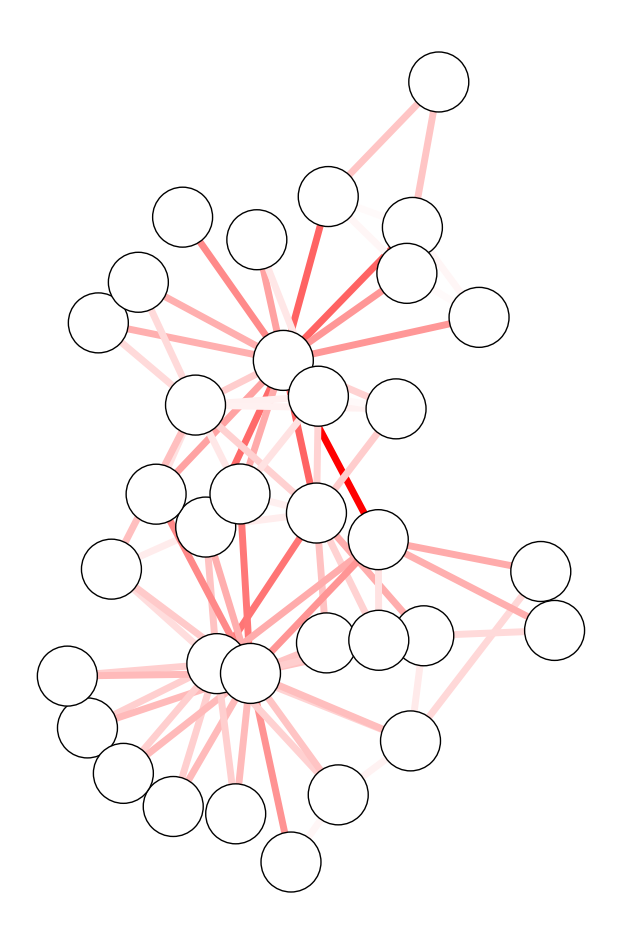

In [42]:
G = ig.Graph.Famous("Zachary")
# For coloring we map betweenness values to integers from 0 to 255
# To make differences more pronounced we use square of the betweenness
bet = np.array(G.edge_betweenness())
ecolors = [ int(x) for x in ((bet / bet.max())*255) ]
palette = ig.drawing.colors.AdvancedGradientPalette(["white", "red"], n=256)

style = dict(edge_width=5, palette=palette)

fig, ax = plt.subplots(figsize=(12, 12))
_ = ig.plot(G, target=ax, edge_color=ecolors, **style)

We can now try to use edge betweenness to partition the graph into two main groups. The logic of this process is simple.

1. Find the edge with the highest betweenness and remove it.
2. Check if the graph has been decomposed into two disconnected clusters.
3. If not, recalculcate betweenness scores and repeat.

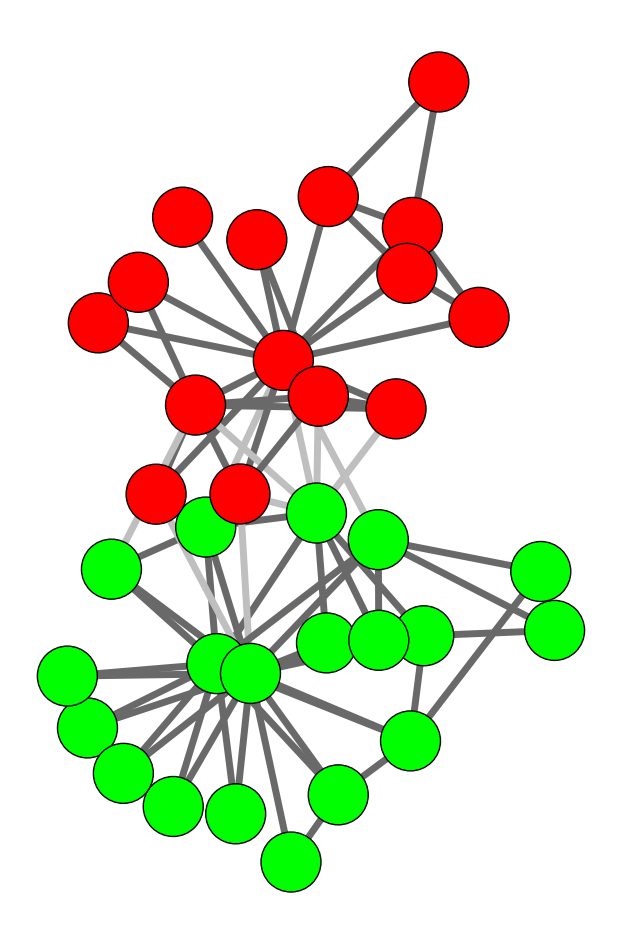

In [43]:
# Copy the graph
U = G.copy()

while U.is_connected():
    bet = U.edge_betweenness()
    idxmax = bet.index(max(bet))
    U.delete_edges([idxmax])

for idx, component in enumerate(U.components()):
    # Assign cluster memberships on the original graph
    G.vs.select(component)["cluster"] = idx

# Now we define `VertexClustering` objects on the original graph
# based on the disconnected components our process produced
clustering = ig.VertexClustering(G, G.vs["cluster"])

fig, ax = plt.subplots(figsize=(12, 12))
_ = ig.plot(clustering, target=ax, edge_width=5)

## Brief overview of plotting

Here we discuss, very briefly, the plotting capabilities of `igraph`. It is quite versatile in this respect as it can be used to draw graphs
using multiple plotting backends such [Cairo](https://www.cairographics.org/), [plotly](https://plotly.com/) and [matplotlib](https://matplotlib.org/).
Here we will focus exclusively on the **matplotlib backend**, as matplotlib is the de facto standard for scientific visualizations with Python.
It is very powerful and flexible, even if not very user-friendly.

### Configuration

It is most convenient to use `igraph` configuration to specify default plotting options. This is what we did in the very beginning of this notebook.
Below we do this once again as a reminder. You can read more about `igraph` config features in [the docs](https://python.igraph.org/en/stable/configuration.html).

In [44]:
# Set configuration variables
ig.config["plotting.backend"] = "matplotlib"  # use Matplotlib as plotting backend
ig.config["plotting.vertex_color"] = "white"
ig.config["plotting.vertex_size"] = "0.5"
ig.config["plotting.edge_width"] = "5"

Now we will use the Karate Club network again and produce a slightly more fany visualization than before.
We will **community detection** (which we will discuss later) to find the main groups, mark the groups with convex hull markers,
scale vertex sizes according to vertex degree and color edges by betweenness while also producing a legible colorbar explaining
the mapping between colors and values.

Through this process we will learn most importants techniques and tricks for visualizing graphs.

In [45]:
G = ig.Graph.Famous("Zachary")
## Find 'communities'
## Here we call an algorithm which is just a fancier version of what we did previously
comm = G.community_edge_betweenness(clusters=2)
comm

## Degree sequence (as Numpy array)
degseq = np.array(G.degree())
## Save node degree as attributes
## This will be useful for defining drawing order
## So smaller nodes are drawn on top of larger nodes
G.vs["degree"] = degseq

We specified `ig.config["plotting.backend"] = "matplotlib"` option, which means we do not have to provide `igraph` we `matplotlib`
figure and axes objects explicitly to draw a graph. However, it is very often convenient to do so anyway, as this way we can more
easily leverage advanced functionalities of `matplotlib` such as drawing figures with multiple panels. In order to illustrate this,
we will draw the graph together with a histogram of its degree distribution.

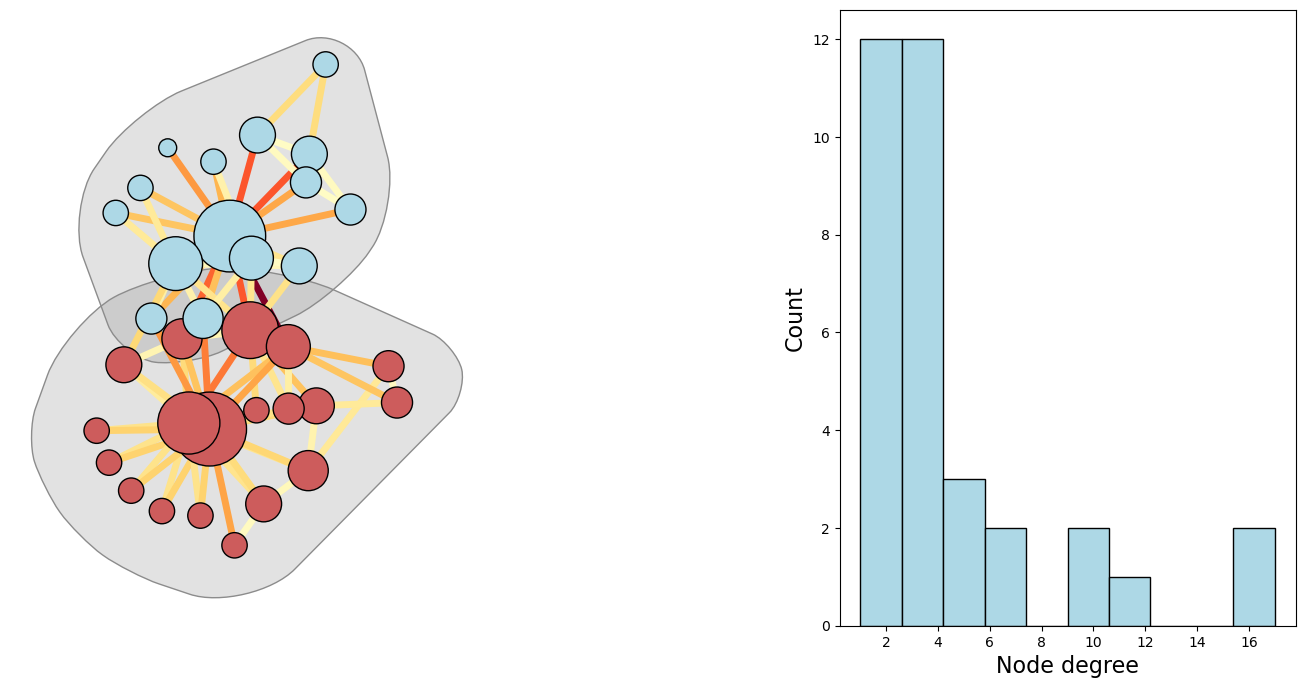

In [46]:
# '.as_clustering()' method transform community detection result
# into an object representing graph clustering which can be used for plotting
clustering = comm.as_clustering()

# Calculate edge betweenness and define color palette for 
bet = np.array(G.edge_betweenness())

# Define vertex drawing options
# We keep them in a separate dict to make it easy to modify and redraw
# the plot multiple times
vertex_opts = {
    "vertex_size":  np.sqrt(degseq/degseq.max()),   # set vertex sizes proportional to the square root of degree
    "vertex_color": np.where(                       # assign vertex colors according to cluster membership
        [ i == 0 for i in clustering.membership ], "lightblue", "indianred"
    ),
    "vertex_order_by": ("degree", "desc"),         # draw nodes with large degrees first (descending order according 'degree' attribute that we set earlier)
}

# Define edge drawing options
# Again, as a separate dict for the same reasons
cmap = mpl.cm.YlOrRd
edge_opts = {
    "edge_color": [ cmap(int(b*255)) for b in bet/bet.max() ],
}

# Define options for marking groups
groups_opts = {
    "mark_groups": { tuple(c): "gray55" for c in clustering }
}

fig, axes = plt.subplot_mosaic("AAB", figsize=(20, 8))
_ = ig.plot(G, target=axes["A"], **vertex_opts, **edge_opts, **groups_opts)

# Draw histogram of degree distribution in the second panel
ax = axes["B"]
ax.hist(degseq, edgecolor="black", color="lightblue")
ax.set_xlabel("Node degree", fontsize=16)
_ = ax.set_ylabel("Count", fontsize=16)

That is nice, but it would be even better to have a colorbar explaining how edge between is mapped to colors.
We add it below.

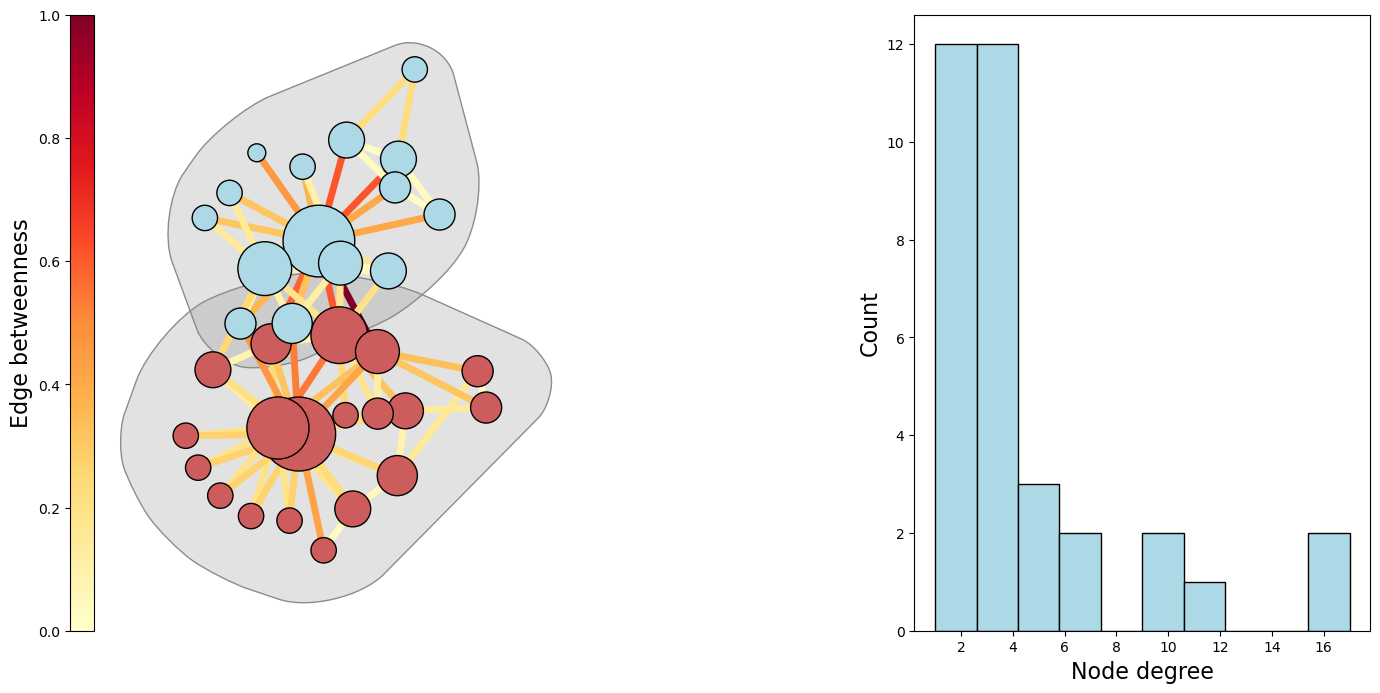

In [47]:
# Import some extra Matplotlib magic for positioning colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax=axes["A"]
# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=0.05)
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap), cax=cax)
cax.set_ylabel("Edge betweenness", fontsize=16)
cax.yaxis.set_label_position("left")
cax.yaxis.set_ticks_position("left")
fig

### Layout

We managed to produce a relatively nice figure. However, there is a lot of unused space on the right side of the left panel.
Can we do something about it? Probably it would make sense to rotate the graph 90 degrees clockwise.
To do this we need to understand how `igraph` actually draws graphs.

Graphs are usually drawn by mapping nodes to positions in (usually 2D) Euclidean space. This can be achieved in many ways,
but the typical logic most of drawing algorithms follow assumes that connected nodes should be close to each other,
unconnected far away, and links should not cross as much as possible (this condition is realizable for all pairs of edges only for so-called planar graphs).

`igraph` implements many layout algorithms targeting different usecases and we will not review them here (but check the official documentation).
Instead, we will use just one, which typically works very well, and focus on how to work with `Layout` objects `igraph` more generally.

So, we will now compute Kamada-Kawai layout for our graph.
Kamada-Kawai is very effective algorithm based on physical principles, which models the graph as a system of masses connected by springs.

**NOTE.**

Kamada-Kawai is used by default by the latest version of `igraph`, but this may change in the future.

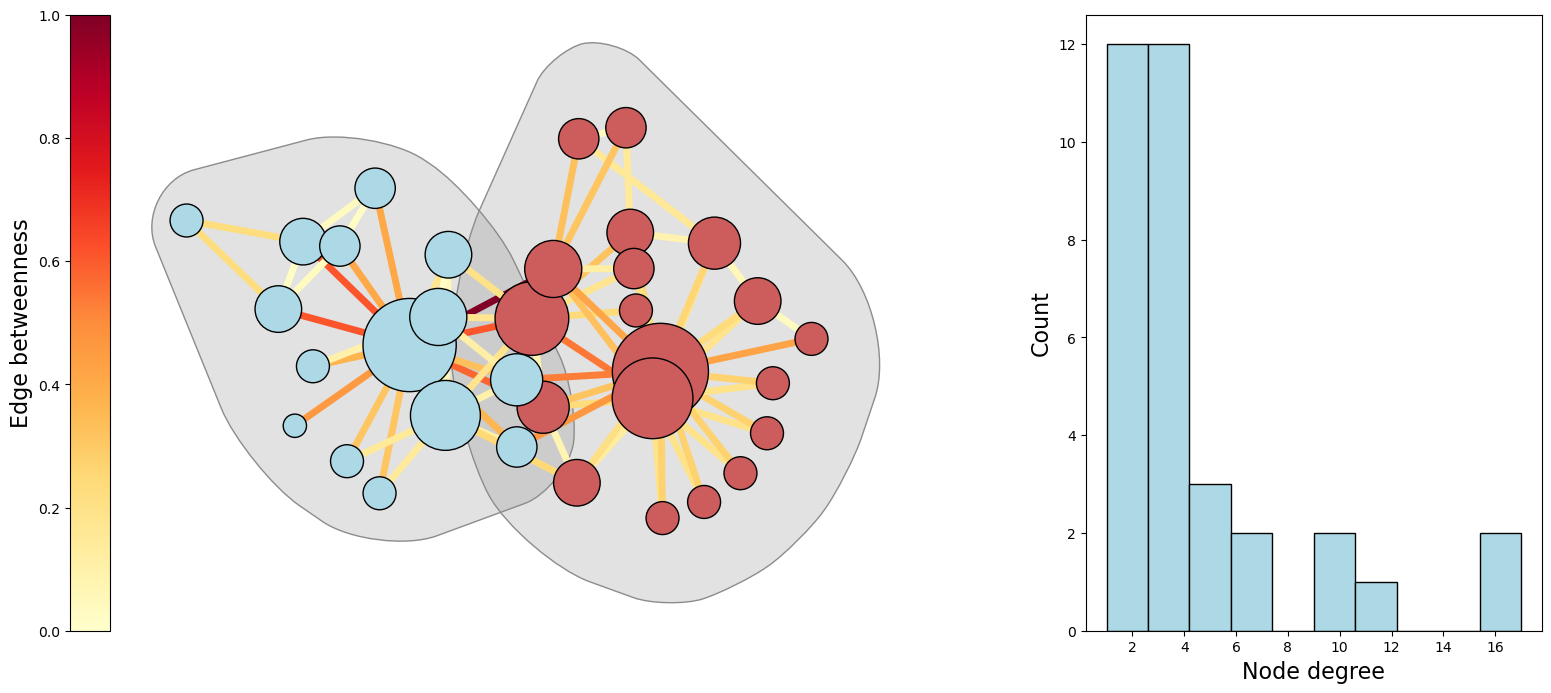

In [48]:
# Calculate Kamada-Kawai layout
layout = G.layout_kamada_kawai()
# Rotate the layout by 90 degrees
layout.rotate(90)

# Draw the plot again
fig, axes = plt.subplot_mosaic("AAB", figsize=(20, 8))
_ = ig.plot(
    G, target=axes["A"], layout=layout,          # NOTE. We now specify the layout explictly
    **vertex_opts, **edge_opts, **groups_opts
)

# Draw histogram of degree distribution in the second panel
ax = axes["B"]
ax.hist(degseq, edgecolor="black", color="lightblue")
ax.set_xlabel("Node degree", fontsize=16)
_ = ax.set_ylabel("Count", fontsize=16)

ax=axes["A"]
# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=0.05)
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap), cax=cax)
cax.set_ylabel("Edge betweenness", fontsize=16)
cax.yaxis.set_label_position("left")
cax.yaxis.set_ticks_position("left")

## Homework

1. Go through this notebook at your own pace. Play with the code (especially in parts which are confusing), by changing some parameters and observing
   changes in the results. This is a very good way of developing an intuitive understanding of software systems.
2. Read the official `igraph` [tutorial](https://python.igraph.org/en/stable/tutorial.html).
It is also recommended to take a look at some examples from the [gallery](https://python.igraph.org/en/stable/tutorials/index.html).
3. Read chapters 4 and 5 and sections 6.1-6.4, 6.8-6.12 from _Networks_ by M. Newman.